In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
#  Holt-Winters ETS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
import statsmodels.api as sm
import pmdarima as pm
import sklearn.metrics as skmetrics

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

/var/folders/jq/7jhfmgd96z7d57jn6j0zc2nr0000gn/T/ipykernel_71728/3179699621.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [6]:
df_zillow = pd.read_csv('zillow-carlifornia.csv', parse_dates=['Date'])
df_zillow.rename(columns={'MedianSoldPrice_AllHomes.California':'sold_price'},inplace=True)

In [5]:
df_test = pd.read_csv('test.csv', parse_dates=['Month'])
df_test.rename(columns={'Month':'Date'},inplace=True)

In [7]:
train = df_zillow[df_zillow.Date<'2016-01-31'].copy()
test = df_zillow[df_zillow.Date>='2016-01-31'].copy()
test['sold_price'] = df_test['Median House Price'].values

In [13]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

train_sc = sc.fit_transform(train.iloc[:,1:].values )
test_sc = sc.transform(test.iloc[:,1:].values )

df_train_sc = pd.DataFrame(train_sc,columns=['sold_price','MedianMortageRate','UnemploymentRate'])


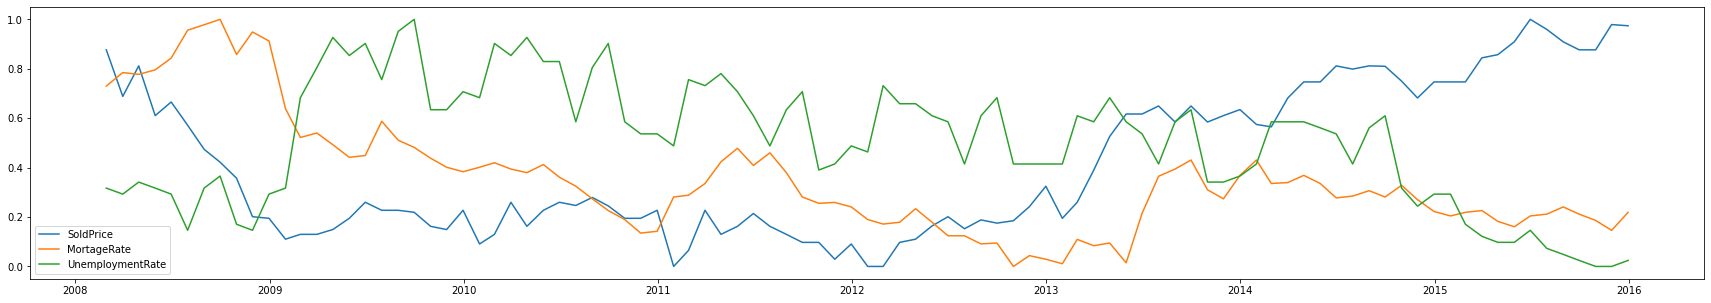

In [15]:
fig = plt.figure(figsize=(30, 5))
ax = fig.add_subplot(111)
#fig = plt.figure(figsize=(30, 5))

ax.plot(df_train_sc.set_index(train['Date']).sold_price, label = 'SoldPrice')
ax.plot(df_train_sc.set_index(train['Date']).MedianMortageRate, label = 'MortageRate')
ax.plot(df_train_sc.set_index(train['Date']).UnemploymentRate, label = 'UnemploymentRate')
ax.legend()
plt.show()

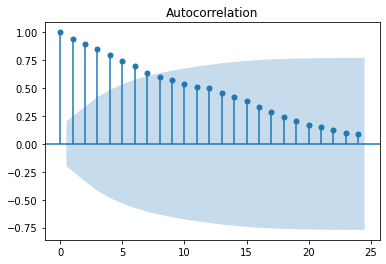

In [16]:
plot_acf(train.sold_price,lags=24) 
plt.show()


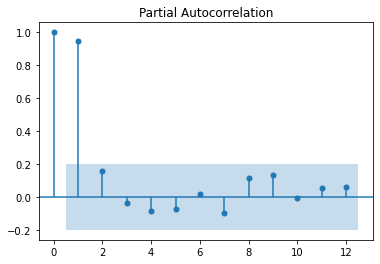

In [17]:
plot_pacf(train.sold_price,lags=12) 
plt.show()

In [18]:
#ADF Fuller test
dftest = adfuller(train.sold_price)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
print (dfoutput)

Test Statistic   -0.058792
p-value           0.953391
dtype: float64


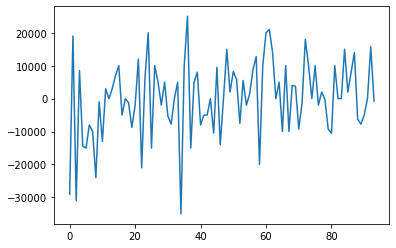

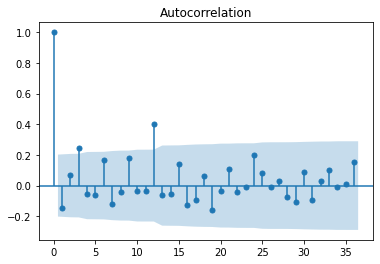

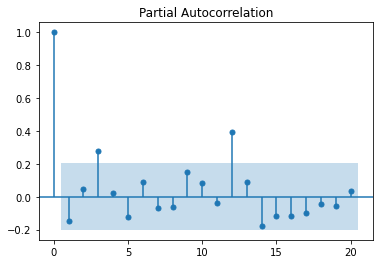

In [19]:
#Differencing
def diff(data, interval=1):
    diff = list()
    for i in range(interval, len(data)):
        value = data[i] - data[i - interval]
        diff.append(value)
    return diff

# fit a trend only model 
# determine d
d1 = diff(train.sold_price, 1)
plt.plot(d1)
plot_acf(d1,lags=36) 
plt.show()
plot_pacf(d1,lags=20) 
plt.show()

In [20]:
diff_1 = diff(train.sold_price,interval=1)
dftest = adfuller(diff_1)
dfoutput = pd.Series(dftest[0:2], index=['Test Statistic', 'p-value'])
print(dfoutput)

Test Statistic   -3.088139
p-value           0.027443
dtype: float64


### SARIMAX model:

In [23]:
def evaluate_sarimax_model(data1, data2, trend_order, seasonal_order, split):
    train_size = int(len(data1) * split)
    sc1 = MinMaxScaler(feature_range = (0,1))
    sc2 = MinMaxScaler(feature_range = (0,1))
    
    train_data1, test_data1 = data1[0:train_size], data1.iloc[train_size:]
    train_data2, test_data2 = data2[0:train_size], data2.iloc[train_size:]
    
    sc1.fit(train_data1.iloc[:train_size].values.reshape(-1, 1))
    sc2.fit(train_data2.iloc[:train_size].values)
    
    data1_sc = sc1.transform(data1.values.reshape(-1, 1))
    data2_sc = sc2.transform(data2.values)
    
    predictions = list()
    for t in tqdm(range(len(test_data1))):
        model = sm.tsa.statespace.SARIMAX(data1_sc[:train_size+t],exog=data2_sc[:train_size+t,:], order=trend_order,seasonal_order=seasonal_order) #rolling forward for one step at each time
        model_fit = model.fit()
        y_hat = np.asanyarray(model_fit.forecast(exog=data2_sc[train_size+t,:]))[0] #predict one step
        y_pred_inv = sc1.inverse_transform(y_hat.reshape(1, -1))[:,0]
        predictions.append(y_pred_inv) #store prediction
    predictions = np.asarray(predictions).reshape(-1,)
    test = np.asanyarray(test_data1).reshape(-1,)
    rmse = np.sqrt(skmetrics.mean_squared_error(test_data1, predictions))
    mape = mean_absolute_percentage_error(test_data1, predictions)
    return rmse, mape

### Model 1: Both exogenous variables

In [21]:
model1 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-215.712, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-238.288, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.241, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-217.701, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-215.233, Time=0.11 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-236.319, Time=0.53 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-236.333, Time=0.29 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-233.728, Time=0.12 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-234.368, Time=0.45 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-237.576, Time=0.13 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-240.100, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-213.848, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-238.185, Time=0.77 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-238.221, Time=0.32 sec
 ARIMA(2,1,0)(0,0,1

In [22]:
y_pred = model1.predict(n_periods=len(test_sc),X=test_sc[:,1:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [27]:
trend_order = (1,1,2)
seasonal_order= (1,0,0,12)
rmse1, mape1 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,3:4], trend_order, seasonal_order, split=0.8)

  5%|██▉                                                    | 1/19 [00:00<00:03,  5.57it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10227D+00    |proj g|=  1.19268D+00

At iterate    5    f= -1.11365D+00    |proj g|=  1.49629D+00

At iterate   10    f= -1.15414D+00    |proj g|=  2.27826D-01

At iterate   15    f= -1.20643D+00    |proj g|=  2.07682D-01

At iterate   20    f= -1.21284D+00    |proj g|=  1.32926D-01

At iterate   25    f= -1.21290D+00    |proj g|=  5.64526D-03

At iterate   30    f= -1.21291D+00    |proj g|=  1.41078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 11%|█████▊                                                 | 2/19 [00:00<00:02,  5.69it/s] This problem is unconstrained.



At iterate   10    f= -1.15875D+00    |proj g|=  1.75733D-01

At iterate   15    f= -1.18353D+00    |proj g|=  5.22493D-01

At iterate   20    f= -1.20083D+00    |proj g|=  3.25316D-01

At iterate   25    f= -1.21551D+00    |proj g|=  6.27916D-02

At iterate   30    f= -1.21564D+00    |proj g|=  4.58405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     46      1     0     0   4.885D-04  -1.216D+00
  F =  -1.2156403508001294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 16%|████████▋                                              | 3/19 [00:00<00:02,  5.64it/s] This problem is unconstrained.



At iterate   20    f= -1.20545D+00    |proj g|=  1.49056D-01

At iterate   25    f= -1.21304D+00    |proj g|=  1.73934D-01

At iterate   30    f= -1.22271D+00    |proj g|=  2.35715D-01

At iterate   35    f= -1.22292D+00    |proj g|=  5.98562D-02

At iterate   40    f= -1.22293D+00    |proj g|=  1.04292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     48      1     0     0   1.043D-03  -1.223D+00
  F =  -1.2229300416648694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 21%|███████████▌                                           | 4/19 [00:00<00:03,  4.76it/s]

At iterate   25    f= -1.21918D+00    |proj g|=  3.43282D-01

At iterate   30    f= -1.22509D+00    |proj g|=  1.52681D-01

At iterate   35    f= -1.22525D+00    |proj g|=  9.06655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     78      2     0     0   9.067D-05  -1.225D+00
  F =  -1.2252500760985849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12403D+00    |proj g|=  1.16905D+00

At itera

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 26%|██████████████▍                                        | 5/19 [00:00<00:02,  4.84it/s] This problem is unconstrained.



At iterate   15    f= -1.19813D+00    |proj g|=  2.25542D+00

At iterate   20    f= -1.21829D+00    |proj g|=  1.02279D-01

At iterate   25    f= -1.23067D+00    |proj g|=  2.25160D-02

At iterate   30    f= -1.23068D+00    |proj g|=  3.96078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     57      1     0     0   7.434D-05  -1.231D+00
  F =  -1.2306808648297101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 32%|█████████████████▎                                     | 6/19 [00:01<00:02,  5.03it/s] This problem is unconstrained.



At iterate   15    f= -1.18837D+00    |proj g|=  7.91619D-01

At iterate   20    f= -1.20793D+00    |proj g|=  1.08293D+00

At iterate   25    f= -1.23224D+00    |proj g|=  6.64036D-02

At iterate   30    f= -1.23625D+00    |proj g|=  4.51150D-03

At iterate   35    f= -1.23626D+00    |proj g|=  6.91900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     48      1     0     0   2.944D-04  -1.236D+00
  F =  -1.2362637085701580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 37%|████████████████████▎                                  | 7/19 [00:01<00:02,  4.90it/s]


At iterate   25    f= -1.20002D+00    |proj g|=  1.74325D-01

At iterate   30    f= -1.21245D+00    |proj g|=  8.41638D-01

At iterate   35    f= -1.22232D+00    |proj g|=  8.19942D-01

At iterate   40    f= -1.22954D+00    |proj g|=  1.17682D-01

At iterate   45    f= -1.22959D+00    |proj g|=  4.47478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58      1     0     0   2.266D-04  -1.230D+00
  F =  -1.2295876578742373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 42%|███████████████████████▏                               | 8/19 [00:01<00:02,  5.16it/s] This problem is unconstrained.


At iterate   20    f= -1.21711D+00    |proj g|=  3.71076D-01

At iterate   25    f= -1.23417D+00    |proj g|=  1.03149D-01

At iterate   30    f= -1.23546D+00    |proj g|=  6.67434D-03

At iterate   35    f= -1.23547D+00    |proj g|=  1.19920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     46      1     0     0   1.199D-03  -1.235D+00
  F =  -1.2354650513258398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 47%|██████████████████████████                             | 9/19 [00:01<00:02,  4.63it/s]


At iterate   30    f= -1.21726D+00    |proj g|=  2.10314D-01

At iterate   35    f= -1.23007D+00    |proj g|=  9.17260D-02

At iterate   40    f= -1.23339D+00    |proj g|=  5.57340D-02

At iterate   45    f= -1.23341D+00    |proj g|=  2.14653D-03

At iterate   50    f= -1.23341D+00    |proj g|=  6.43952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     0     0   6.440D-04  -1.233D+00
  F =  -1.2334147969759894     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 53%|████████████████████████████▍                         | 10/19 [00:02<00:01,  4.74it/s] This problem is unconstrained.



At iterate   20    f= -1.19817D+00    |proj g|=  8.97559D-02

At iterate   25    f= -1.21059D+00    |proj g|=  7.83990D-01

At iterate   30    f= -1.23058D+00    |proj g|=  3.18911D-01

At iterate   35    f= -1.23273D+00    |proj g|=  1.47986D-02

At iterate   40    f= -1.23274D+00    |proj g|=  4.61173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     52      1     0     0   4.612D-04  -1.233D+00
  F =  -1.2327405274677152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 58%|███████████████████████████████▎                      | 11/19 [00:02<00:01,  4.79it/s]

At iterate   20    f= -1.20537D+00    |proj g|=  4.52925D-01

At iterate   25    f= -1.22263D+00    |proj g|=  1.36014D-01

At iterate   30    f= -1.23617D+00    |proj g|=  1.12083D-01

At iterate   35    f= -1.23621D+00    |proj g|=  4.72343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   3.688D-04  -1.236D+00
  F =  -1.2362080544727254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 63%|██████████████████████████████████                    | 12/19 [00:02<00:01,  4.87it/s] This problem is unconstrained.



At iterate   20    f= -1.20929D+00    |proj g|=  6.89839D-01

At iterate   25    f= -1.22523D+00    |proj g|=  1.63169D+00

At iterate   30    f= -1.24066D+00    |proj g|=  3.59555D-02

At iterate   35    f= -1.24115D+00    |proj g|=  1.80786D-02

At iterate   40    f= -1.24118D+00    |proj g|=  4.37880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     49      1     0     0   4.379D-05  -1.241D+00
  F =  -1.2411812542816387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 68%|████████████████████████████████████▉                 | 13/19 [00:02<00:01,  4.42it/s]


At iterate   25    f= -1.23663D+00    |proj g|=  7.26196D-01

At iterate   30    f= -1.24668D+00    |proj g|=  1.86102D-02

At iterate   35    f= -1.24669D+00    |proj g|=  9.90622D-04

At iterate   40    f= -1.24669D+00    |proj g|=  1.12197D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     77      2     0     0   7.264D-04  -1.247D+00
  F =  -1.2466896972428780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 74%|███████████████████████████████████████▊              | 14/19 [00:02<00:01,  4.46it/s]


At iterate   10    f= -1.19939D+00    |proj g|=  4.17637D-01

At iterate   15    f= -1.20250D+00    |proj g|=  2.35149D-01

At iterate   20    f= -1.21377D+00    |proj g|=  9.51680D-01

At iterate   25    f= -1.22402D+00    |proj g|=  7.98137D-02

At iterate   30    f= -1.24738D+00    |proj g|=  3.62353D-01

At iterate   35    f= -1.25061D+00    |proj g|=  6.55583D-02

At iterate   40    f= -1.25064D+00    |proj g|=  4.98956D-03

At iterate   45    f= -1.25064D+00    |proj g|=  3.70642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     56      1     0     0   3.155D-04  -1.251D+00
  F =  -1.25064363569

 This problem is unconstrained.



At iterate   10    f= -1.20200D+00    |proj g|=  4.31046D-01

At iterate   15    f= -1.20513D+00    |proj g|=  1.97144D-01

At iterate   20    f= -1.21428D+00    |proj g|=  8.95026D-01

At iterate   25    f= -1.23126D+00    |proj g|=  8.77325D-02

At iterate   30    f= -1.25419D+00    |proj g|=  9.32037D-02

At iterate   35    f= -1.25439D+00    |proj g|=  2.35680D-02

At iterate   40    f= -1.25444D+00    |proj g|=  1.41167D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 79%|██████████████████████████████████████████▋           | 15/19 [00:03<00:00,  4.16it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     78      2     0     0   4.156D-04  -1.254D+00
  F =  -1.2544393836467749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16048D+00    |proj g|=  1.43769D+00

At iterate    5    f= -1.17118D+00    |proj g|=  1.40831D+00

At iterate   10    f= -1.19707D+00    |proj g|=  4.05593D-01

At iterate   15    f= -1.20011D+00    |proj g|=  1.98220D-01

At iter

 89%|████████████████████████████████████████████████▎     | 17/19 [00:03<00:00,  4.64it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16493D+00    |proj g|=  1.43608D+00

At iterate    5    f= -1.17545D+00    |proj g|=  1.40503D+00

At iterate   10    f= -1.20143D+00    |proj g|=  4.20637D-01

At iterate   15    f= -1.20405D+00    |proj g|=  1.61778D-01

At iterate   20    f= -1.21026D+00    |proj g|=  7.77056D-01

At iterate   25    f= -1.22932D+00    |proj g|=  1.51453D-01

At iterate   30    f= -1.25233D+00    |proj g|=  4.85700D-02

At iterate   35    f= -1.25246D+00    |proj g|=  2.73550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 95%|███████████████████████████████████████████████████▏  | 18/19 [00:03<00:00,  4.66it/s]


At iterate    5    f= -1.18039D+00    |proj g|=  1.39636D+00

At iterate   10    f= -1.20607D+00    |proj g|=  4.09603D-01

At iterate   15    f= -1.20838D+00    |proj g|=  1.65722D-01

At iterate   20    f= -1.21346D+00    |proj g|=  2.78181D-01

At iterate   25    f= -1.23381D+00    |proj g|=  1.08783D+00

At iterate   30    f= -1.25724D+00    |proj g|=  1.44250D-01

At iterate   35    f= -1.25812D+00    |proj g|=  8.24071D-03

At iterate   40    f= -1.25814D+00    |proj g|=  1.69770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     53      1     0     0   1.388D-03  -1.258D+00
  F =  -1.25814088799

 This problem is unconstrained.
100%|██████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.77it/s]


At iterate    5    f= -1.17052D+00    |proj g|=  1.39282D+00

At iterate   10    f= -1.17879D+00    |proj g|=  3.05835D-01

At iterate   15    f= -1.18241D+00    |proj g|=  1.52928D-01

At iterate   20    f= -1.18454D+00    |proj g|=  1.56360D-01

At iterate   25    f= -1.20315D+00    |proj g|=  6.06223D-01

At iterate   30    f= -1.22574D+00    |proj g|=  8.55722D-02

At iterate   35    f= -1.22629D+00    |proj g|=  5.21169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   3.139D-04  -1.226D+00
  F =  -1.2262859348166830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [28]:
rmse1

9086.401171260351

### Model 2: Only Median Mortgage Rate

In [30]:
model2 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,1:2], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model2.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-215.475, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-239.081, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-233.407, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-217.471, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-215.420, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-237.142, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-237.170, Time=0.31 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-233.959, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-235.225, Time=0.61 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-238.215, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-240.480, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-213.886, Time=0.06 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-238.579, Time=0.58 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-238.623, Time=0.28 sec
 ARIMA(2,1,0)(0,0,1

In [31]:
trend_order = (1,1,2)
seasonal_order= (1,0,0,12)
rmse2, mape2 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,2:3], trend_order, seasonal_order, split=0.8)

  5%|██▉                                                    | 1/19 [00:00<00:03,  5.42it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.11769D+00    |proj g|=  1.84284D+00

At iterate    5    f= -1.13303D+00    |proj g|=  1.20392D+00

At iterate   10    f= -1.18757D+00    |proj g|=  1.06765D-01

At iterate   15    f= -1.20835D+00    |proj g|=  2.25830D-01

At iterate   20    f= -1.23086D+00    |proj g|=  1.74651D-01

At iterate   25    f= -1.23300D+00    |proj g|=  3.57126D-01

At iterate   30    f= -1.23361D+00    |proj g|=  2.08602D-02

At iterate   35    f= -1.23364D+00    |proj g|=  5.08560D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 11%|█████▊                                                 | 2/19 [00:00<00:02,  5.84it/s] This problem is unconstrained.


At iterate    5    f= -1.13970D+00    |proj g|=  1.11719D+00

At iterate   10    f= -1.19660D+00    |proj g|=  1.11066D-01

At iterate   15    f= -1.20379D+00    |proj g|=  1.42858D+00

At iterate   20    f= -1.22996D+00    |proj g|=  1.99003D-01

At iterate   25    f= -1.23794D+00    |proj g|=  3.71698D-02

At iterate   30    f= -1.24061D+00    |proj g|=  8.29636D-03

At iterate   35    f= -1.24061D+00    |proj g|=  2.05073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     43      1     0     0   2.051D-03  -1.241D+00
  F =  -1.2406090701452250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH    

 16%|████████▋                                              | 3/19 [00:00<00:02,  5.47it/s] This problem is unconstrained.



At iterate   25    f= -1.24387D+00    |proj g|=  3.92386D-02

At iterate   30    f= -1.24612D+00    |proj g|=  9.33048D-02

At iterate   35    f= -1.24632D+00    |proj g|=  1.05765D-02

At iterate   40    f= -1.24632D+00    |proj g|=  1.38806D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     54      1     0     0   1.509D-04  -1.246D+00
  F =  -1.2463194311985011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 26%|██████████████▍                                        | 5/19 [00:00<00:02,  5.84it/s]


At iterate   30    f= -1.24842D+00    |proj g|=  1.43995D-02

At iterate   35    f= -1.24848D+00    |proj g|=  3.56713D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     45      1     0     0   5.825D-05  -1.248D+00
  F =  -1.2484808485017300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14108D+00    |proj g|=  1.82314D+00

At iterate    5    f= -1.15288D+00    |proj g|=  9.84853D-01

At iter

 This problem is unconstrained.
 32%|█████████████████▎                                     | 6/19 [00:01<00:02,  5.59it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14623D+00    |proj g|=  1.89942D+00

At iterate    5    f= -1.15822D+00    |proj g|=  9.64914D-01

At iterate   10    f= -1.20293D+00    |proj g|=  7.78918D-01

At iterate   15    f= -1.22493D+00    |proj g|=  2.34277D-01

At iterate   20    f= -1.25188D+00    |proj g|=  9.79672D-02

At iterate   25    f= -1.25561D+00    |proj g|=  2.35415D-01

At iterate   30    f= -1.26009D+00    |proj g|=  6.54670D-02

At iterate   35    f= -1.26067D+00    |proj g|=  1.14392D-02

At iterate   40    f= -1.26068D+00    |proj g|=  6.81088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 37%|████████████████████▎                                  | 7/19 [00:01<00:02,  5.79it/s] This problem is unconstrained.



At iterate    5    f= -1.15131D+00    |proj g|=  9.62423D-01

At iterate   10    f= -1.19454D+00    |proj g|=  7.07985D-01

At iterate   15    f= -1.21686D+00    |proj g|=  2.05138D-01

At iterate   20    f= -1.24188D+00    |proj g|=  8.68095D-01

At iterate   25    f= -1.25134D+00    |proj g|=  7.53253D-02

At iterate   30    f= -1.25165D+00    |proj g|=  2.76311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     39      1     0     0   2.410D-05  -1.252D+00
  F =  -1.2516510885317869     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 42%|███████████████████████▏                               | 8/19 [00:01<00:02,  5.00it/s]


At iterate   20    f= -1.24683D+00    |proj g|=  6.50318D-01

At iterate   25    f= -1.25377D+00    |proj g|=  4.45723D-02

At iterate   30    f= -1.25800D+00    |proj g|=  4.49365D-02

At iterate   35    f= -1.25823D+00    |proj g|=  4.78977D-04

At iterate   40    f= -1.25823D+00    |proj g|=  1.51106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     72      2     0     0   1.511D-04  -1.258D+00
  F =  -1.2582314347347356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 47%|██████████████████████████                             | 9/19 [00:01<00:01,  5.11it/s] This problem is unconstrained.



At iterate   15    f= -1.21851D+00    |proj g|=  1.35581D-01

At iterate   20    f= -1.23482D+00    |proj g|=  8.49472D-01

At iterate   25    f= -1.24798D+00    |proj g|=  2.74960D-01

At iterate   30    f= -1.25631D+00    |proj g|=  3.48522D-02

At iterate   35    f= -1.25661D+00    |proj g|=  4.08630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     50      1     0     0   4.086D-04  -1.257D+00
  F =  -1.2566111428692759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 53%|████████████████████████████▍                         | 10/19 [00:01<00:01,  5.08it/s] This problem is unconstrained.



At iterate   20    f= -1.24041D+00    |proj g|=  3.28227D-01

At iterate   25    f= -1.25097D+00    |proj g|=  5.30898D-02

At iterate   30    f= -1.25737D+00    |proj g|=  1.74495D-01

At iterate   35    f= -1.25803D+00    |proj g|=  1.70915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     52      1     0     0   3.672D-04  -1.258D+00
  F =  -1.2580312399826057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 58%|███████████████████████████████▎                      | 11/19 [00:02<00:01,  5.19it/s] This problem is unconstrained.



At iterate   25    f= -1.26357D+00    |proj g|=  4.89805D-02

At iterate   30    f= -1.26379D+00    |proj g|=  3.18417D-03

At iterate   35    f= -1.26379D+00    |proj g|=  1.06176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   7.323D-04  -1.264D+00
  F =  -1.2637885227597283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16438D+00    |proj g|=  1.97807D+00

At iter

 63%|██████████████████████████████████                    | 12/19 [00:02<00:01,  5.13it/s]


At iterate   35    f= -1.26336D+00    |proj g|=  1.98690D-03

At iterate   40    f= -1.26336D+00    |proj g|=  1.40902D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     51      1     0     0   9.042D-04  -1.263D+00
  F =  -1.2633601171324951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16971D+00    |proj g|=  2.03209D+00

At iterate    5    f= -1.18100D+00    |proj g|=  8.45677D-01

At iter

 This problem is unconstrained.
 68%|████████████████████████████████████▉                 | 13/19 [00:02<00:01,  5.21it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     48      1     0     0   2.164D-03  -1.269D+00
  F =  -1.2691661325976467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16674D+00    |proj g|=  2.09805D+00

At iterate    5    f= -1.17880D+00    |proj g|=  8.73036D-01

At iterate   10    f= -1.21800D+00    |proj g|=  8.29286D-01

At iterate   15    f= -1.22902D+00    |proj g|=  1.22904D-01

At iter

 74%|███████████████████████████████████████▊              | 14/19 [00:02<00:00,  5.17it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17169D+00    |proj g|=  2.10860D+00

At iterate    5    f= -1.18435D+00    |proj g|=  9.61037D-01

At iterate   10    f= -1.21640D+00    |proj g|=  4.33440D-01

At iterate   15    f= -1.23485D+00    |proj g|=  3.72327D-01

At iterate   20    f= -1.26070D+00    |proj g|=  9.62668D-02

At iterate   25    f= -1.26663D+00    |proj g|=  7.99958D-02

At iterate   30    f= -1.26946D+00    |proj g|=  1.09308D-01

At iterate   35    f= -1.27007D+00    |proj g|=  1.09395D-01

At iterate   40    f= -1.27080D+00    |proj g|=  3.90485D-03

At iterate   45    f= -1.27081D+00    |proj g|=  3.84435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 84%|█████████████████████████████████████████████▍        | 16/19 [00:03<00:00,  4.94it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16926D+00    |proj g|=  1.97214D+00

At iterate    5    f= -1.17981D+00    |proj g|=  8.13587D-01

At iterate   10    f= -1.20986D+00    |proj g|=  4.53485D-01

At iterate   15    f= -1.22145D+00    |proj g|=  1.26498D-01

At iterate   20    f= -1.23182D+00    |proj g|=  6.99284D-01

At iterate   25    f= -1.25174D+00    |proj g|=  6.69151D-02

At iterate   30    f= -1.25851D+00    |proj g|=  5.73290D-01

At iterate   35    f= -1.26472D+00    |proj g|=  4.53647D-02

At iterate   40    f= -1.26476D+00    |proj g|=  7.09904D-03

At iterate   45    f= -1.26476D+00    |proj g|=  4.88473D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17325D+00    |proj g|=  1.96887D+00

At iterate    5    f= -1.18357D+00    |proj g|=  7.99551D-01

At iterate   10    f= -1.21504D+00    |proj g|=  5.72762D-01

At iterate   15    f= -1.22496D+00    |proj g|=  1.39101D-01

At iterate   20    f= -1.23440D+00    |proj g|=  8.09666D-01

At iterate   25    f= -1.26123D+00    |proj g|=  3.80618D-01

At iterate   30    f= -1.26398D+00    |proj g|=  9.50086D-03

At iterate   35    f= -1.26399D+00    |proj g|=  9.62595D-03

At iterate   40    f= -1.26399D+00    |proj g|=  7.56528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 95%|███████████████████████████████████████████████████▏  | 18/19 [00:03<00:00,  4.92it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.17790D+00    |proj g|=  1.93272D+00

At iterate    5    f= -1.18791D+00    |proj g|=  8.08649D-01

At iterate   10    f= -1.21746D+00    |proj g|=  4.61885D-01

At iterate   15    f= -1.22773D+00    |proj g|=  7.84108D-02

At iterate   20    f= -1.23254D+00    |proj g|=  5.12746D-01

At iterate   25    f= -1.24111D+00    |proj g|=  7.95194D-01

At iterate   30    f= -1.26296D+00    |proj g|=  6.83291D-01

At iterate   35    f= -1.26834D+00    |proj g|=  7.82424D-02

At iterate   40    f= -1.26838D+00    |proj g|=  1.15466D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

100%|██████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.10it/s]


In [32]:
rmse2

9879.978379846367

### Model 3 : Only Unemployment Rate

In [40]:
model3 = pm.auto_arima(train_sc[:,0], 
                      exogenous= train_sc[:,2:3], 
                      start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=12,              # seasonal is set to False
                      d=1,           # let model determine 'd'
                      seasonal=True,   
                      start_P=0, start_Q=0,
                      max_P=3, max_Q=3,
                      max_D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model3.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-217.045, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-238.335, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-234.637, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-219.015, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-216.832, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-236.335, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-236.335, Time=0.24 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-235.137, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-234.352, Time=0.53 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-237.478, Time=0.09 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-238.326, Time=0.19 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=-237.008, Time=0.24 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-237.561, Time=0.13 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-242.921, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0

In [33]:
trend_order = (1,1,2)
seasonal_order= (1,0,0,12)
rmse3, mape3 = evaluate_sarimax_model(train.iloc[:,1],train.iloc[:,3:4], trend_order, seasonal_order, split=0.8)

  5%|██▉                                                    | 1/19 [00:00<00:03,  5.76it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.10227D+00    |proj g|=  1.19268D+00

At iterate    5    f= -1.11365D+00    |proj g|=  1.49629D+00

At iterate   10    f= -1.15414D+00    |proj g|=  2.27826D-01

At iterate   15    f= -1.20643D+00    |proj g|=  2.07682D-01

At iterate   20    f= -1.21284D+00    |proj g|=  1.32926D-01

At iterate   25    f= -1.21290D+00    |proj g|=  5.64526D-03

At iterate   30    f= -1.21291D+00    |proj g|=  1.41078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 11%|█████▊                                                 | 2/19 [00:00<00:02,  5.80it/s] This problem is unconstrained.



At iterate   10    f= -1.15875D+00    |proj g|=  1.75733D-01

At iterate   15    f= -1.18353D+00    |proj g|=  5.22493D-01

At iterate   20    f= -1.20083D+00    |proj g|=  3.25316D-01

At iterate   25    f= -1.21551D+00    |proj g|=  6.27916D-02

At iterate   30    f= -1.21564D+00    |proj g|=  4.58405D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     46      1     0     0   4.885D-04  -1.216D+00
  F =  -1.2156403508001294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 16%|████████▋                                              | 3/19 [00:00<00:02,  5.70it/s] This problem is unconstrained.



At iterate   20    f= -1.20545D+00    |proj g|=  1.49056D-01

At iterate   25    f= -1.21304D+00    |proj g|=  1.73934D-01

At iterate   30    f= -1.22271D+00    |proj g|=  2.35715D-01

At iterate   35    f= -1.22292D+00    |proj g|=  5.98562D-02

At iterate   40    f= -1.22293D+00    |proj g|=  1.04292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     48      1     0     0   1.043D-03  -1.223D+00
  F =  -1.2229300416648694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 21%|███████████▌                                           | 4/19 [00:00<00:03,  4.80it/s]


At iterate   30    f= -1.22509D+00    |proj g|=  1.52681D-01

At iterate   35    f= -1.22525D+00    |proj g|=  9.06655D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     78      2     0     0   9.067D-05  -1.225D+00
  F =  -1.2252500760985849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12403D+00    |proj g|=  1.16905D+00

At iterate    5    f= -1.14715D+00    |proj g|=  2.10445D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 26%|██████████████▍                                        | 5/19 [00:00<00:02,  4.86it/s]


At iterate   15    f= -1.19813D+00    |proj g|=  2.25542D+00

At iterate   20    f= -1.21829D+00    |proj g|=  1.02279D-01

At iterate   25    f= -1.23067D+00    |proj g|=  2.25160D-02

At iterate   30    f= -1.23068D+00    |proj g|=  3.96078D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     57      1     0     0   7.434D-05  -1.231D+00
  F =  -1.2306808648297101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 32%|█████████████████▎                                     | 6/19 [00:01<00:02,  5.04it/s] This problem is unconstrained.


At iterate   15    f= -1.18837D+00    |proj g|=  7.91619D-01

At iterate   20    f= -1.20793D+00    |proj g|=  1.08293D+00

At iterate   25    f= -1.23224D+00    |proj g|=  6.64036D-02

At iterate   30    f= -1.23625D+00    |proj g|=  4.51150D-03

At iterate   35    f= -1.23626D+00    |proj g|=  6.91900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     48      1     0     0   2.944D-04  -1.236D+00
  F =  -1.2362637085701580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 37%|████████████████████▎                                  | 7/19 [00:01<00:02,  4.36it/s]


At iterate   25    f= -1.20002D+00    |proj g|=  1.74325D-01

At iterate   30    f= -1.21245D+00    |proj g|=  8.41638D-01

At iterate   35    f= -1.22232D+00    |proj g|=  8.19942D-01

At iterate   40    f= -1.22954D+00    |proj g|=  1.17682D-01

At iterate   45    f= -1.22959D+00    |proj g|=  4.47478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     58      1     0     0   2.266D-04  -1.230D+00
  F =  -1.2295876578742373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 42%|███████████████████████▏                               | 8/19 [00:01<00:02,  4.63it/s] This problem is unconstrained.



At iterate    5    f= -1.16317D+00    |proj g|=  2.48800D+00

At iterate   10    f= -1.18002D+00    |proj g|=  1.15717D-01

At iterate   15    f= -1.19093D+00    |proj g|=  5.86746D-01

At iterate   20    f= -1.21711D+00    |proj g|=  3.71076D-01

At iterate   25    f= -1.23417D+00    |proj g|=  1.03149D-01

At iterate   30    f= -1.23546D+00    |proj g|=  6.67434D-03

At iterate   35    f= -1.23547D+00    |proj g|=  1.19920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     46      1     0     0   1.199D-03  -1.235D+00
  F =  -1.2354650513258398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/vishpra/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 47%|██████████████████████████                             | 9/19 [00:01<00:02,  4.31it/s]


At iterate   15    f= -1.18074D+00    |proj g|=  3.45694D-01

At iterate   20    f= -1.19063D+00    |proj g|=  8.36431D-01

At iterate   25    f= -1.19480D+00    |proj g|=  4.38704D-01

At iterate   30    f= -1.21726D+00    |proj g|=  2.10314D-01

At iterate   35    f= -1.23007D+00    |proj g|=  9.17260D-02

At iterate   40    f= -1.23339D+00    |proj g|=  5.57340D-02

At iterate   45    f= -1.23341D+00    |proj g|=  2.14653D-03

At iterate   50    f= -1.23341D+00    |proj g|=  6.43952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     73      1     0     0   6.440D-04  -1.233D+00
  F =  -1.23341479697

 This problem is unconstrained.
 53%|████████████████████████████▍                         | 10/19 [00:02<00:01,  4.50it/s] This problem is unconstrained.



At iterate    5    f= -1.15352D+00    |proj g|=  1.62879D+00

At iterate   10    f= -1.18396D+00    |proj g|=  2.83115D-01

At iterate   15    f= -1.18881D+00    |proj g|=  2.55387D-01

At iterate   20    f= -1.19817D+00    |proj g|=  8.97559D-02

At iterate   25    f= -1.21059D+00    |proj g|=  7.83990D-01

At iterate   30    f= -1.23058D+00    |proj g|=  3.18911D-01

At iterate   35    f= -1.23273D+00    |proj g|=  1.47986D-02

At iterate   40    f= -1.23274D+00    |proj g|=  4.61173D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     52      1     0     0   4.612D-04  -1.233D+00
  F =  -1.23274052746

 58%|███████████████████████████████▎                      | 11/19 [00:02<00:01,  4.61it/s]


At iterate   10    f= -1.18807D+00    |proj g|=  4.56881D-02

At iterate   15    f= -1.19424D+00    |proj g|=  2.91598D-01

At iterate   20    f= -1.20537D+00    |proj g|=  4.52925D-01

At iterate   25    f= -1.22263D+00    |proj g|=  1.36014D-01

At iterate   30    f= -1.23617D+00    |proj g|=  1.12083D-01

At iterate   35    f= -1.23621D+00    |proj g|=  4.72343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     54      1     0     0   3.688D-04  -1.236D+00
  F =  -1.2362080544727254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 63%|██████████████████████████████████                    | 12/19 [00:02<00:01,  4.79it/s] This problem is unconstrained.



At iterate   10    f= -1.19412D+00    |proj g|=  6.19047D-02

At iterate   15    f= -1.19987D+00    |proj g|=  4.87802D-01

At iterate   20    f= -1.20929D+00    |proj g|=  6.89839D-01

At iterate   25    f= -1.22523D+00    |proj g|=  1.63169D+00

At iterate   30    f= -1.24066D+00    |proj g|=  3.59555D-02

At iterate   35    f= -1.24115D+00    |proj g|=  1.80786D-02

At iterate   40    f= -1.24118D+00    |proj g|=  4.37880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     49      1     0     0   4.379D-05  -1.241D+00
  F =  -1.2411812542816387     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 68%|████████████████████████████████████▉                 | 13/19 [00:02<00:01,  4.20it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     77      2     0     0   7.264D-04  -1.247D+00
  F =  -1.2466896972428780     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.15547D+00    |proj g|=  1.52978D+00

At iterate    5    f= -1.16832D+00    |proj g|=  1.53516D+00

At iterate   10    f= -1.19939D+00    |proj g|=  4.17637D-01

At iterate   15    f= -1.20250D+00    |proj g|=  2.35149D-01

At iter

 74%|███████████████████████████████████████▊              | 14/19 [00:03<00:01,  4.30it/s]


At iterate   45    f= -1.25064D+00    |proj g|=  3.70642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     56      1     0     0   3.155D-04  -1.251D+00
  F =  -1.2506436356983148     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16039D+00    |proj g|=  1.52538D+00

At iterate    5    f= -1.17267D+00    |proj g|=  1.50205D+00

At iterate   10    f= -1.20200D+00    |proj g|=  4.31046D-01

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 79%|██████████████████████████████████████████▋           | 15/19 [00:03<00:00,  4.06it/s] This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     78      2     0     0   4.156D-04  -1.254D+00
  F =  -1.2544393836467749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16048D+00    |proj g|=  1.43769D+00

At iterate    5    f= -1.17118D+00    |proj g|=  1.40831D+00

At iterate   10    f= -1.19707D+00    |proj g|=  4.05593D-01

At iterate   15    f= -1.20011D+00    |proj g|=  1.98220D-01

At iter

 89%|████████████████████████████████████████████████▎     | 17/19 [00:03<00:00,  4.56it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.16493D+00    |proj g|=  1.43608D+00

At iterate    5    f= -1.17545D+00    |proj g|=  1.40503D+00

At iterate   10    f= -1.20143D+00    |proj g|=  4.20637D-01

At iterate   15    f= -1.20405D+00    |proj g|=  1.61778D-01

At iterate   20    f= -1.21026D+00    |proj g|=  7.77056D-01

At iterate   25    f= -1.22932D+00    |proj g|=  1.51453D-01

At iterate   30    f= -1.25233D+00    |proj g|=  4.85700D-02

At iterate   35    f= -1.25246D+00    |proj g|=  2.73550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 95%|███████████████████████████████████████████████████▏  | 18/19 [00:03<00:00,  4.61it/s]


At iterate    5    f= -1.18039D+00    |proj g|=  1.39636D+00

At iterate   10    f= -1.20607D+00    |proj g|=  4.09603D-01

At iterate   15    f= -1.20838D+00    |proj g|=  1.65722D-01

At iterate   20    f= -1.21346D+00    |proj g|=  2.78181D-01

At iterate   25    f= -1.23381D+00    |proj g|=  1.08783D+00

At iterate   30    f= -1.25724D+00    |proj g|=  1.44250D-01

At iterate   35    f= -1.25812D+00    |proj g|=  8.24071D-03

At iterate   40    f= -1.25814D+00    |proj g|=  1.69770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     53      1     0     0   1.388D-03  -1.258D+00
  F =  -1.25814088799

 This problem is unconstrained.
100%|██████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.64it/s]


At iterate    5    f= -1.17052D+00    |proj g|=  1.39282D+00

At iterate   10    f= -1.17879D+00    |proj g|=  3.05835D-01

At iterate   15    f= -1.18241D+00    |proj g|=  1.52928D-01

At iterate   20    f= -1.18454D+00    |proj g|=  1.56360D-01

At iterate   25    f= -1.20315D+00    |proj g|=  6.06223D-01

At iterate   30    f= -1.22574D+00    |proj g|=  8.55722D-02

At iterate   35    f= -1.22629D+00    |proj g|=  5.21169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     46      1     0     0   3.139D-04  -1.226D+00
  F =  -1.2262859348166830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [34]:
pd.DataFrame([[rmse1],[rmse2],[rmse3]],columns=['RMSE'],index=['Both','Mortgage Rate only','Unemployment Rate'])

,RMSE
Both,9086.401171
Mortgage Rate only,9879.978380
Unemployment Rate,9086.401171


In [37]:
test

,Date,sold_price,MedianMortageRate,UnemploymentRate
95,2016-01-31,476250,3.91,5.0
96,2016-02-29,466000,3.96,4.9
97,2016-03-31,485000,3.60,5.0
98,2016-04-30,501000,3.60,5.0
99,2016-05-31,501000,3.59,4.8
100,2016-06-30,505000,3.59,4.8
101,2016-07-31,507000,3.46,4.9
102,2016-08-31,510000,3.46,4.8
103,2016-09-30,510000,3.42,5.0
104,2016-10-31,523000,3.36,5.0


# Final prediction on test set

In [58]:
#test_sc= sc.transform(test)
y_pred = model3.predict(n_periods=len(test_sc),X=test_sc[:,2:]).reshape(-1,1)
y_pred_ = np.repeat(y_pred,3,axis=1) # duplicate the pred column x3 times to fit the scaler's shape
y_pred_inv = sc.inverse_transform(y_pred_)[:,0]# inverset the pred and take the first column (gdp)

In [59]:
y_pred_inv

array([486946.44102671, 490424.76595997, 502816.14386228, 506167.84380725,
       511526.36626294, 520756.14552901, 519682.34054458, 515803.36410088,
       515085.97499132, 516210.54571282, 525399.94886081, 524679.25636712])

In [61]:
mape_test_sarimax=(np.abs(np.array(test['sold_price'])-np.array(y_pred_inv))/np.array(test['sold_price'])).mean()
print(mape_test_sarimax)

0.025050358408763837


### Final RMSE for SARIMAX

In [63]:
np.sqrt(skmetrics.mean_squared_error(test['sold_price'], np.array(y_pred_inv)))

13761.323683327188